In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=875f3e3adb761f9742cde3d669d6b15b0f14844c821e3110cf49d14b7f0c7e1b
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import os, cv2, json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB4
from keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [3]:
# Clear any logs from previous tensorboard runs
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [4]:
from google.colab import files
data_to_load = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [01:02<00:00, 102MB/s] 
100% 5.76G/5.76G [01:02<00:00, 99.4MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('cassava-leaf-disease-classification.zip', 'r')
zip_ref.extractall('cassava-leaf-disease-classification')
zip_ref.close()

In [8]:
WORK_DIR = os.getcwd()+'/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['test_images',
 'label_num_to_disease_map.json',
 'train_tfrecords',
 'train_images',
 'train.csv',
 'test_tfrecords',
 'sample_submission.csv']

In [9]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [10]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [11]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


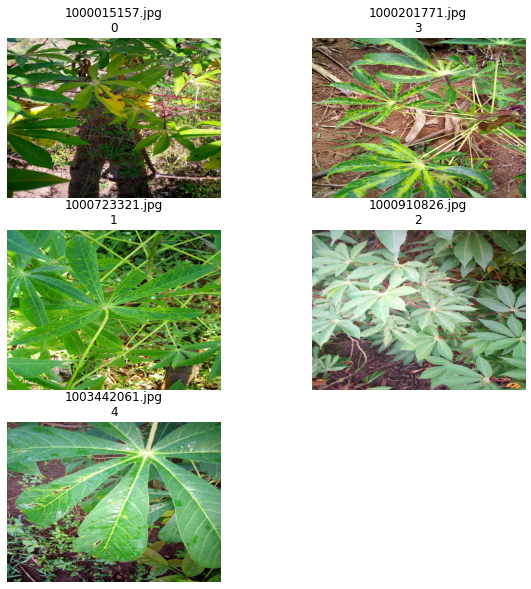

In [12]:
# Image sample from 5 different classes
sample_images = ['1000015157.jpg','1000723321.jpg','1000910826.jpg','1000201771.jpg','1003442061.jpg']
sample_images_df = train_labels[train_labels.image_id.isin(sample_images)]
plt.figure(figsize=(10,10))
for ind, (image_id, label) in enumerate(zip(sample_images_df.image_id, sample_images_df.label)):
    plt.subplot(3, 2, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title('{}\n{}'.format(image_id,label))
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

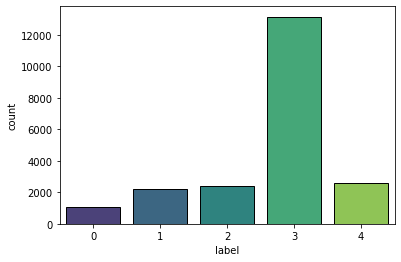

In [13]:
sns.countplot(train_labels.label, edgecolor = 'black',
              palette = sns.color_palette("viridis", 5))
plt.show()

We have imbalanced data with domination of third class: "Cassava Mosaic Disease (CMD)". Let's see how our model performs with this imbalanced dataset and so we will keep it in the training dataset for now.

### Some photos of dominant class (with CMD)

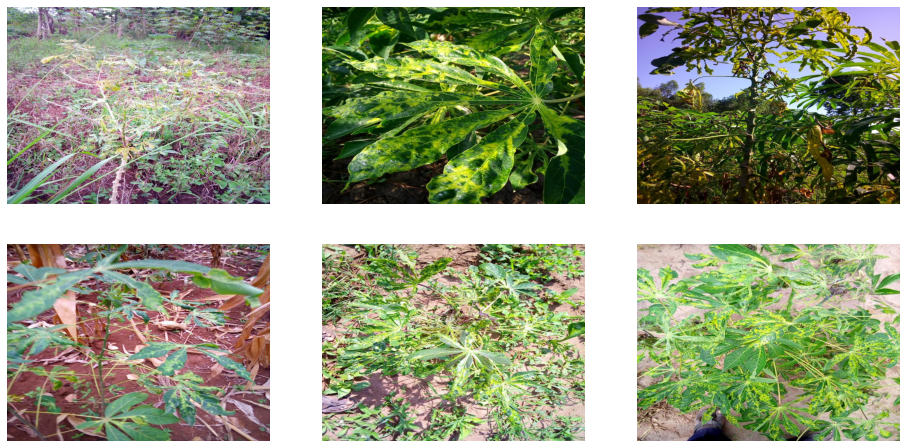

In [14]:
sample = train_labels[train_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

### Some photos of healthy plants

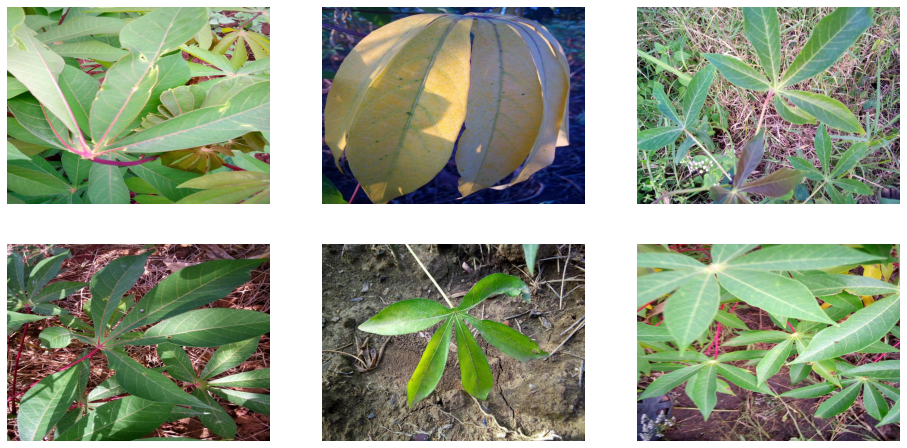

In [15]:
sample = train_labels[train_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

## The baseline level of accuracy

In [16]:
y_pred = [3] * len(train_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, train_labels.label,normalize=True))

The baseline accuracy: 0.615


Our future model must have accuracy better than 0.615.

## Image Preprocessing

In [17]:
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 10
TARGET_SIZE = 299

In [18]:
train_labels.label = train_labels.label.astype('str')
#validation_split parameter allows for us to split 20% of the data into the validation set automatically without train test split
#Then you can allow .flow_from_dataframe to breakout the train versus validation in the data
train_generator = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     rotation_range = 5,
                                     fill_mode = 'constant',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


## Modeling

I will try EfficientNetB4. It will be my baseline NN for future improvements.

In [19]:
def create_model():
    model = models.Sequential()

    model.add(EfficientNetB4(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [20]:
model = create_model()

71688192/71686520 [==============================] - 1s 0us/step


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 10, 10, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,788
Trainable params: 17,557,581
Non-trainable params: 125,207
_________________________________________________________________


In [22]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,                                     histogram_freq=1)
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [tensorboard_callback,model_save, early_stop, reduce_lr]
    )

Epoch 1/10
   1/1069 [..............................] - ETA: 0s - loss: 1.6010 - acc: 0.2500WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1070/1069 [==============================] - ETA: 0s - loss: 0.6505 - acc: 0.7721
Epoch 00001: val_loss improved from inf to 0.77554, saving model to ./best_baseline_model.h5
1070/1069 [==============================] - 580s 542ms/step - loss: 0.6505 - acc: 0.7721 - val_loss: 0.7755 - val_acc: 0.7481
Epoch 2/10
1070/1069 [==============================] - ETA: 0s - loss: 0.5108 - acc: 0.8263
Epoch 00002: val_loss improved from 0.77554 to 0.54717, saving model to ./best_baseline_model.h5
1070/1069 [==============================] - 574s 536ms/step - loss: 0.5108 - acc: 0.8263 - val_loss: 0.5472 - val_acc: 0.8091
Epoch 3/10


In [ ]:

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, accuracy, "bo", label = "Training acc")
ax1.plot(epochs, val_accuracy, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [ ]:

model.save('./baseline_model.h5')

In [ ]:

ss = pd.read_csv(os.path.join(WORK_DIR, "sample_submission.csv"))
ss

In [ ]:

preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(WORK_DIR,  "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

ss['label'] = preds
ss

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:

ss.to_csv('submission.csv', index = False)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

In [ ]:

os.chdir(os.getcwd()+'/drive/MyDrive/Cassava-Leaf-Disease-Classification')
print('The Current Working Directory is: ',os.getcwd())

In [ ]:

model.save('./baseline_model.h5')

Next items:

1. Apply Test Time Augmentation to increase scores
2. Scale images to larger than 299 x 299 x 3: Maybe try 448x448x3
3. Try other EfficientNetB architectures to see if model improves
4. Try oversampling other classification groups to rectify any loss or accuracy deprivation as a result of imbalanced data tied to CMD class